In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data = pd.read_csv('data/GI_comment.csv')
data.head()

,Comment,Vote_useful,Date,Rating
0,The game in general is the best I've ever play...,32,"August 23, 2022",5
1,I absolutely love and adore this game. By far ...,643,"August 16, 2022",5
2,"It is amazing, I have only been playing it for...",396,"August 21, 2022",4
3,This game is truly amazing and getting better ...,188,"August 19, 2022",4
4,The release of Sumeru gave so much to do! I've...,91,"September 5, 2022",4


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Comment      2040 non-null   object
 1   Vote_useful  2040 non-null   object
 2   Date         2040 non-null   object
 3   Rating       2040 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 63.9+ KB


# Preprocessing And Cleaning

In [4]:
data.isnull().sum()

Comment        0
Vote_useful    0
Date           0
Rating         0
dtype: int64

<font size="4">There are no null values</font>

In [5]:
index_dup = data.duplicated()
data[index_dup]

,Comment,Vote_useful,Date,Rating
896,"This game is really fun to play with, but I'm ...",0,"August 14, 2022",4


<font size="4">There are 1 duplicated row</font>

In [6]:
data = data.drop_duplicates()

## Process With Date Column

In [7]:
data['fixed_Date'] = pd.to_datetime(data['Date'])
data.head()

,Comment,Vote_useful,Date,Rating,fixed_Date
0,The game in general is the best I've ever play...,32,"August 23, 2022",5,2022-08-23
1,I absolutely love and adore this game. By far ...,643,"August 16, 2022",5,2022-08-16
2,"It is amazing, I have only been playing it for...",396,"August 21, 2022",4,2022-08-21
3,This game is truly amazing and getting better ...,188,"August 19, 2022",4,2022-08-19
4,The release of Sumeru gave so much to do! I've...,91,"September 5, 2022",4,2022-09-05


In [8]:
data = data.drop(columns=['Date'])
data.head()

,Comment,Vote_useful,Rating,fixed_Date
0,The game in general is the best I've ever play...,32,5,2022-08-23
1,I absolutely love and adore this game. By far ...,643,5,2022-08-16
2,"It is amazing, I have only been playing it for...",396,4,2022-08-21
3,This game is truly amazing and getting better ...,188,4,2022-08-19
4,The release of Sumeru gave so much to do! I've...,91,4,2022-09-05


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2039 entries, 0 to 2039
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Comment      2039 non-null   object        
 1   Vote_useful  2039 non-null   object        
 2   Rating       2039 non-null   int64         
 3   fixed_Date   2039 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 79.6+ KB


## Process With Vote_useful Column

In [10]:
for i in range(len(data.Vote_useful)):
    data.Vote_useful.iloc[i] = data.Vote_useful.iloc[i].replace(',', '')

c:\users\administrator\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
data.Vote_useful = data.Vote_useful.astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2039 entries, 0 to 2039
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Comment      2039 non-null   object        
 1   Vote_useful  2039 non-null   int32         
 2   Rating       2039 non-null   int64         
 3   fixed_Date   2039 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 71.7+ KB


## Process With Comment Column

### Remove  " ' " From Comment

In [12]:
for i in range(len(data.Comment)):
    data.Comment.iloc[i] = data.Comment.iloc[i].replace("'", "")
    data.Comment.iloc[i] = data.Comment.iloc[i].lower()

In [13]:
data.Comment.iloc[1]

'i absolutely love and adore this game. by far my favorite story roleplaying game out there. the quests, lore, plots, mysteries, grind, pulls, all of it. im a newer player, but i havent been bored yet of this game. i dont think i ever will. id say its biggest issues is lagging, and setting its quality different on its own. as well as occasional bugs on my laptop. if the frame per second(fps) could be a bit quicker that would be great. but other than that, the game is beautiful. will update.'

### Remove None Character From Comment

In [14]:
lst_ = []
for i in data.Comment:
    clean_sample = re.sub(r"[^a-zA-Z0-9.]+", ' ', i)
    lst_.append(clean_sample)
data['fixed_Comment'] = lst_

### Remove Stopwords

In [168]:
def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    text_split = text.split()
    text = [word for word in text_split if word not in stop]
    return ' '.join(text)

data['fixed_Comment'] = data['fixed_Comment'].apply(remove_stopwords)

### Lemmatization

In [169]:
lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v)
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN


def lemmatize_text(text):
    lemmatized = []
    post_tag_list = pos_tag(word_tokenize(text))
    for word, post_tag_val in post_tag_list:
        lemmatized.append(lemmatizer.lemmatize(word, get_wordnet_pos(post_tag_val)))
    text = ' '.join(x for x in lemmatized)
    return text
data['fixed_Comment'] = data['fixed_Comment'].apply(lemmatize_text)

### Using list of negative and positive words

In [170]:
negative_file = open("data/sentiment/negative_words.txt", "r")
negative_list = negative_file.readlines()
for pos_word in range(len(negative_list)):
    negative_list[pos_word] = negative_list[pos_word].replace('\n', '')

In [171]:
positive_file = open("data/sentiment/positive_words.txt", "r")
positive_list = positive_file.readlines()
for pos_word in range(len(positive_list)):
    positive_list[pos_word] = positive_list[pos_word].replace('\n', '')

### Processing sentiment in comment

* The idea is to replace the words in negative list with 'bad' and positive list with 'good' all over the comments then compute the negative and positive ratio base on the negative and positive words appear in each comments

In [172]:
def process_sentence_sentiment(lst_positive_ratio, lst_negative_ratio):
    for passage in data.fixed_Comment:
        index_sentence = 0
        flag_key_word = False
#------------------------------------------
        count_positive = 0
        count_negative = 0

        for sentence in passage.split('.'):
            for idx_word in range(len(sentence.split(' '))):
                if sentence.split(' ')[idx_word] != '':
                        if sentence.split(' ')[idx_word] in positive_list:
                            data.fixed_Comment = data.fixed_Comment.replace(sentence.split(' ')[idx_word],
                                                                            'good', regex=True)
                            count_positive += 1
                        if sentence.split(' ')[idx_word] in negative_list:
                            data.fixed_Comment = data.fixed_Comment.replace(sentence.split(' ')[idx_word],
                                                                            'bad', regex=True)
                            count_negative += 1
#---------------------process sentiment--------------------------------
        negative_ratio = count_negative/(count_negative + count_positive + 1)
        positive_ratio = count_positive/(count_negative + count_positive + 1)
        lst_negative_ratio.append(negative_ratio)
        lst_positive_ratio.append(positive_ratio)

In [173]:
lst_negative = []
lst_positive = []
process_sentence_sentiment(lst_positive, lst_negative)

In [174]:
df_s = data[['fixed_Comment']]
df_s['negative_ratio'] = lst_negative
df_s['positive_ratio'] = lst_positive
df_s.head()

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16572/1614466589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s['negative_ratio'] = lst_negative
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16572/1614466589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s['positive_ratio'] = lst_positive


,fixed_Comment,negative_ratio,positive_ratio
0,game general good ive ever play term adventure...,0.166667,0.666667
1,abadolutely good good game . far good story ro...,0.428571,0.500000
2,good play day bad lot might becuse stobad need...,0.333333,0.555556
3,game truly good get good day day thobad many b...,0.400000,0.500000
4,relgood sumeru give much ive playing year . ge...,0.166667,0.666667


#### An example of how the process transform the comments

* Using the regrex expression the process may transform incorrectly (such as display tp displgood) but wont affect the output

In [175]:
df_s.fixed_Comment[2037]

'game good music visuals bad late updates new character kit rush archon quest bad anniversary bad really displgood hope team learn badake dont anything good anymore future'

## Feature Engineering

### TIDF Processing

* Base on the rating column of the original dataset, transform to a new format consist of "good" and "bad" where:
 * Good is for rating score > 3
 * Bad is for rating score <= 3

In [176]:
vectorizer = TfidfVectorizer(min_df = 0.02)
vectorizer.fit(df_s['fixed_Comment'])
X = vectorizer.transform(df_s['fixed_Comment'])
X = X.toarray()
print(X)

sample_output = data['Rating']
lst_attitude = []
for i in sample_output:
    if i > 3:
        lst_attitude.append(1) #indicate for good
    elif i <= 3:
        lst_attitude.append(0) #indicate for bad
y = pd.DataFrame(lst_attitude)
y = y.to_numpy()

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.18645483 0.         ... 0.         0.22022076 0.        ]
 [0.38875808 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


#### Attach negative score and positive score back to the dataset for model

In [177]:
X = pd.DataFrame(X)
X[263] = df_s['negative_ratio'].to_numpy()
X[264] = df_s['positive_ratio'].to_numpy()
X.head()

,0,1,2,3,4,5,6,7,8,9,...,255,256,257,258,259,260,261,262,263,264
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.222977,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.166667,0.666667
1,0.000000,0.186455,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.137372,0.000000,0.220221,0.0,0.428571,0.500000
2,0.388758,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.333333,0.555556
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.400000,0.500000
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.19155,0.0,0.000000,0.314973,0.000000,0.0,0.166667,0.666667


### Due to imbalance dataset, SMOTE technique is applied for generating more data of lesser class

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

sm = SMOTE(sampling_strategy='auto', k_neighbors = 11, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [179]:
model = LogisticRegression(solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)
cm = classification_report(y_test, y_pred)
print(model.__class__.__name__)
print(cm, '\n')

LogisticRegression
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       134
           1       0.84      0.77      0.80       274

    accuracy                           0.74       408
   macro avg       0.71      0.73      0.72       408
weighted avg       0.76      0.74      0.75       408
 



In [180]:
models= [LogisticRegression(solver='lbfgs', multi_class='multinomial'), 
         BernoulliNB(), KNeighborsClassifier(n_neighbors=11), 
         RandomForestClassifier(), DecisionTreeClassifier(), AdaBoostClassifier(), 
         XGBClassifier()]
scores= []
test_score = []
train_times = []
names= []

In [181]:
for model in models:
    start= time.time()
    scores.append(cross_val_score(model, X_train, y_train, scoring= 'accuracy', cv= 10).mean())
    end = time.time()
    train_times.append(end-start)
    names.append(model.__class__.__name__)

df= pd.DataFrame(scores, columns=['Score'], index= range(len(models)))
df.insert(1, 'Time', pd.Series(train_times))
df.insert(0, 'Model', pd.Series(names))
df

,Model,Score,Time
0,LogisticRegression,0.780408,0.401930
1,BernoulliNB,0.755171,0.108817
2,KNeighborsClassifier,0.606815,0.224375
3,RandomForestClassifier,0.831533,30.066457
4,DecisionTreeClassifier,0.727502,8.624193
5,AdaBoostClassifier,0.755124,101.987617
6,XGBClassifier,0.809026,2.954808


In [182]:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    test_score.append(score)    
    cm = classification_report(y_test, y_pred)
    print(model.__class__.__name__)
    print(cm, '\n')
df['Test_Score'] = test_score
df

LogisticRegression
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       134
           1       0.84      0.77      0.80       274

    accuracy                           0.74       408
   macro avg       0.71      0.73      0.72       408
weighted avg       0.76      0.74      0.75       408
 

BernoulliNB
              precision    recall  f1-score   support

           0       0.53      0.49      0.51       134
           1       0.76      0.79      0.77       274

    accuracy                           0.69       408
   macro avg       0.64      0.64      0.64       408
weighted avg       0.68      0.69      0.69       408
 

KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.38      0.98      0.54       134
           1       0.95      0.21      0.35       274

    accuracy                           0.46       408
   macro avg       0.66      0.59      0.45       408
weighted avg      

,Model,Score,Time,Test_Score
0,LogisticRegression,0.780408,0.401930,0.742647
1,BernoulliNB,0.755171,0.108817,0.688725
2,KNeighborsClassifier,0.606815,0.224375,0.463235
3,RandomForestClassifier,0.831533,30.066457,0.747549
4,DecisionTreeClassifier,0.727502,8.624193,0.649510
5,AdaBoostClassifier,0.755124,101.987617,0.678922
6,XGBClassifier,0.809026,2.954808,0.720588


Text(0.5, 15.0, 'Predicted Values')

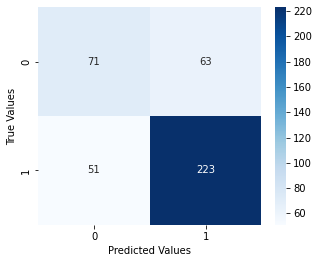

In [183]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, model.predict(X_test))
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot = True, fmt = 'g', cmap= 'Blues')
#plt.title('Accuracy:{0:.3f}'.format(score))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')